<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/P0C1S1/sequences/P0C1_Introduction/P0C1_Sequence1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is part of a test for an upcoming text book on computational neuroscience from an optimization and learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as an optimization algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

___
# **0.1.1: Evolution and Learning as Nested Optimization Processes**
A central theme in our book is that learning processes and structures in the brain are themseleves the targets of evolution. This is a short sequence of interactive exercises and simulations showing how this can work. We use simple, concrete examples to anchor and illustrate this core concept.
### Objective: See how learning and evolution

In this sequence we will:

* Introduce a basic eat-don't-eat binary discrimination task, which defines the ecological niche of a very simple organism.

* Implement an agent based simulation of a process of natural selection acting on inherited variation. This shows how a propose-accept-reject kind  optimization algorithm can discover a good solution in terms of a stimuli-behaviour response map to this binary discrimination problem of what to eat. Because Evolution specifices the the behaviour generating map directly, individuals with the same genotype will express the same behaviours regardless of their past experiences.

* See how this evolutionary process responds to shifts in environment, i.e. what happens when the right kind of thing to eat changes. How long does it take for the population to adapt to the change in ecological niche.

* Adapt the evolutionary model so that now rewards are the target of evolutionary change. Compare the performance of this 'learning' organism with the fixed behaviour function organism for different rates of environmental change. See how this helps with resiliance. Change is the only constant

* Further extend the evolutionary model so that the learning rule itself is also a target of evolution (learning rate or more parameters). Again compare how quickly the population adapts to changes in ecological niche.

* Extend the model yet further allowing the structure of the behaviour generating function to also be a target of evolution. Yet again compare how quickly the population adapts to changes in ecological niche.


# Setup

Run the following cell to setup and install the various dependencies and helper functions for this .

In [1]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**
!apt install libgraphviz-dev > /dev/null 2> /dev/null #colab
!pip install ipympl pygraphviz vibecheck datatops jupyterquiz ucimlrepo > /dev/null 2> /dev/null #google.colab

import asyncio
import requests
from requests.exceptions import RequestException
import numpy as np
import itertools
import collections
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation
import seaborn as sns
import pandas as pd
import pygraphviz as pgv
import ipywidgets as widgets
import time
import logging
import random
import os
import copy
import torch
import warnings
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from io import BytesIO
from enum import Enum
from scipy.spatial.distance import cdist
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown, HTML, Image
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm
from ucimlrepo import fetch_ucirepo

data_set = fetch_ucirepo(id=80)
X = data_set.data.features.values
# Translate the data to have a minimum of 0
X_translated = X - X.min()
# Scale the data to have a range from 0 to 12 (which is 6 - (-6))
scaling_factor = 12 / (X.max() - X.min())
X_scaled = X_translated * scaling_factor
# Finally, shift the data to be centered between -6 and 6
X_final = X_scaled - 6

y = data_set.data.targets.values
rng = np.random.default_rng(seed=2021)
scramble_permutation = rng.permutation(X.shape[1])
Xs = X_final[:, scramble_permutation]
y1 = y % 2
y2 = np.array(y >= 5, dtype=y.dtype)
simple_index = ((y.flatten()==1) | (y.flatten()==0))
X_simple = Xs[simple_index]
y1_simple = y1[simple_index]
# if you only had one feature which would likely be best for discrimination
epsilon = 10
class_a_sep = np.mean(X_simple[y1_simple.flatten() == 1, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 1, :], axis=0) + epsilon)
class_b_sep = np.mean(X_simple[y1_simple.flatten() == 0, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 0, :], axis=0) + epsilon)
best_feature = np.argmax(class_a_sep - class_b_sep)
print(f'Best feature is {best_feature}')
X_simple_1_feature = X_simple[:, [best_feature]]

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("This notebook isn't using and doesn't need a GPU. Good.")
  else:
    print("GPU is enabled in this notebook but not needed.")
    print("If possible, in the menu under `Runtime` -> ")
    print("`Change runtime type.`  select `CPU`")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = []
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  from google.colab import data_table
  data_table.disable_dataframe_formatter()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P0C1_S1"

Best feature is 21
Random seed 2021 has been set.
This notebook isn't using and doesn't need a GPU. Good.
Running in colab


# 0.1.1.1: To Eat Or Not To Eat, That is The Question

In this sequence we consider the life and evolution of a population of cartoonishly simple organisms. The life cycle of this organism is dominated almost entirely by the simple binay decision problem illustrated and described below.

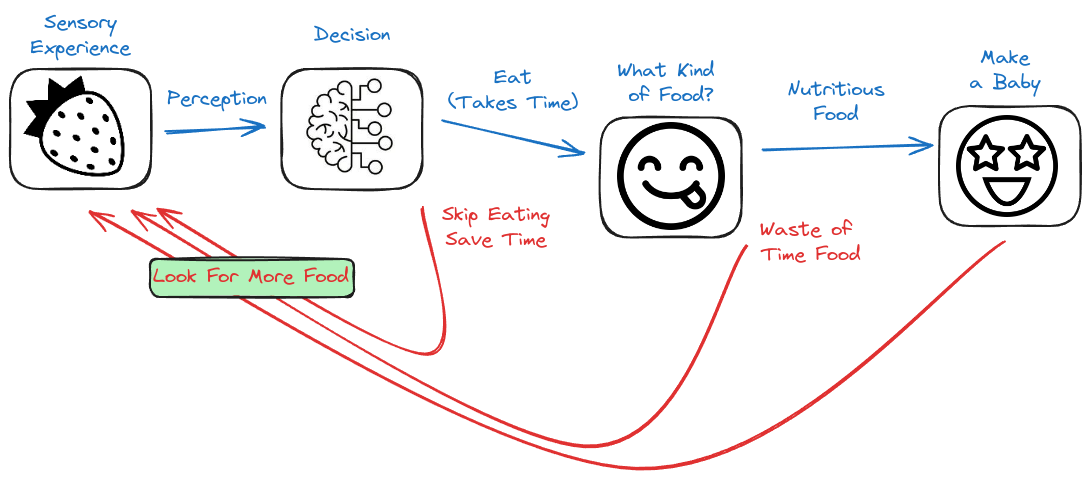

In this simulation an organism's life consist of a series of episodes. Each episode is initiated by the seneory experience of something that the organism might eat. Based on this sensory experience the organism has to make a decision: eat the food, which will take some time and effort; or skip eating and save some time, save some time and effort. If the organism skips eating, then the episode ends after only one time unit (percieving and deciding takes one time unit) of their precisous life on this episode. Alternatively if they choose to eat, they spend an additional time unit of life, and get to see if the food was nutritous or not. If the food was nutritous, they are so fat and happy that they make baby right then and there. If though, the food is not nutritious, they have now wasted a total two time units of their short sweet precious time alive (one unit percieving and deciding, one unit eating) and they have no progeny to show for their effort.

That describes the core activity of the organism in their niche, now let's describe the rest of their life history. These organisms can live for a maximum of 200 time units, at which point they die. Additionally the ecological niche where this population lives can support a maximum of 100 individuals, this means that when the population is at capacity, and new individuals are born, and there have not been enough deaths due to senesence to make space for all the newly spawned individuals, then these new individuals will displace (a nice way of saying kill) an indivdual from the older generation at random (including possibly their parent), (Thus our simulation bears some distant resemblance to  birth-death Moran process). Children mostly resemble their parents. Specifically, how organisms approach the binary discrimination problem described above will depend on a number of real valued parameters. Children will have the same parameter values as their parents, perturbed by Gaussian noise. Note there is no model the specific process of genetic inheritence here.



___
Pedagogy Note: Simple Problems
Throughout this book we will typically ground our discussion in the simplest possible 'toy problems'. Problems are selected for there didactic value, not their realism, or because they definatively prove something. However, as a kind of assurance that we are not playing some kind of 'trick' in using overly simple problems as analogies, we will in the final chapters of the book show how the core concepts introduced in the book can be complexified along two axis of biological plausibility, 1) alignment with known electro-physiology, 2) ability to solve the challenging learning problems like those encountered by real organisms. These more complex models are less useful for understanding principles, which is why they come at the end, but potentially much more useful in describing and predicting data in an empirical setting. In the end data keeps us honest.
___

___
Inetellectual Warning: Agent Based Simulations
There are many seemingly arbitrary choices to be made about life history, that will interact in dramatic and different ways with the core decision problem described above. These seemingly small details in implementation can sometimes totally reverse the interpretation of a given simulation. Care must be taken. For example details like whether or not the organisms act sequentially or simultaneouse (we will pick simultaneously for computational/cognitive ease) or whether we simulation time steps are done on a per episode basis, or a per organism time-unit basis. If the former, an organism that eats everything will reproduce just as fast as an organism that is perfectly selective in what it eats, the only downside of eating everything is potentially dying sooner, and this will not be such a cost given that any individual is likely to be displaced before they scenes. But, if the later an organism that eats everything will reproduce much less frequently than and organism that is perfectly selective. Again we will chose the later so that there is some real selective pressure on discrimination. These are examples to help see how different, equally reasonable seeming implementations can have drastic affect on the outcomes and interpretations. That said, agent based simulations can be imensely usefull for illustrating possibilities or hypotheses.
___

In [ ]:
# @markdown **Run this cell** to try out the 'strike-no-strike' discrimination task.

class InteractiveMNISTPredator():
  def __init__(self,
               features=Xs,
               labels=y,
               feedback_type='on_strike_only', seed=123):
    # Initialize dataset, settings for image scrambling and feedback
    self.features = features
    self.labels = labels
    # features is num_data_points x 64 (reshape to 8x8 for display, each cell 0-16)
    # labels is num_data_points x 1 (values 0-9 or 0/1 depending)
    self.feedback_type = feedback_type
    self.rng = np.random.default_rng(seed)
    sample_order = self.rng.permutation(self.features.shape[0])
    self.features = self.features[sample_order]
    self.labels = self.labels[sample_order]
    # initialize game state
    self.current_index = 0
    self.score = 0
    self.best_possible_score = 0
    self.successful_strikes = 0
    self.failed_strikes = 0
    self.non_strikes = 0
    # Initialize widgets
    self.strike_button = widgets.Button(description='Strike')
    self.no_strike_button = widgets.Button(description='No Strike')
    self.score_display = widgets.Output()
    self.feedback_display = widgets.Output()

    # Initialize the figure for image display
    self.fig, self.ax = plt.subplots(figsize=(4, 4))
    remove_ip_clutter(self.fig)
    self.show_next_image()
    # Bind event handlers
    self.strike_button.on_click(self.on_strike_clicked)
    self.no_strike_button.on_click(self.on_no_strike_clicked)

    # Arrange widgets in a layout
    buttons_layout = widgets.HBox([self.strike_button, self.no_strike_button])
    board_buttons = widgets.VBox([self.fig.canvas, buttons_layout])
    self.ui = widgets.HBox([board_buttons, widgets.VBox([self.score_display,
                                                         self.feedback_display])])

  def show_next_image(self):
    # Display the next image
    image = self.features[self.current_index]
    if len(image) == 64:
        image = image.reshape(8, 8)
    elif len(image) == 1:
      scalar_value = image.flatten()[0]
      # Initialize the 8x8 array with -6 (black)
      image = np.full((8, 8), -6.0)
      # Set the second ring to 6 (white)
      image[1:-1, 1:-1] = 6
      # Set the third (inner ring) back to -6 (black)
      image[2:-2, 2:-2] = -6
      # Assuming scalar_value is already in the range -6 to 6
      #print(scalar_value)
      image[3:-3, 3:-3] = scalar_value
    else:
      raise ValueError(f'Unexpected image shape: {image.shape}')
    # Display the image
    #print(image)
    self.fig.clf()
    self.ax = self.fig.add_subplot(111)
    self.ax.set_xlim(-.5, 7.5)
    self.ax.set_ylim(-0.5, 7.5)
    self.ax.set_aspect('equal')
    self.ax.axis('off')
    self.ax.imshow(image, cmap='gray', vmin=-6, vmax=6)
    self.fig.canvas.draw_idle()  # Force redraw

  def on_strike_clicked(self, button):
    self.process_decision('Strike')

  def on_no_strike_clicked(self, button):
    self.process_decision('No Strike')

  def process_decision(self, decision):
    # freeze buttons while we process
    self.strike_button.disabled = True
    self.no_strike_button.disabled = True

    # Process the user's decision, update score, and provide feedback
    correct_action = 'Strike' if self.labels[self.current_index] == 1 else 'No Strike'
    if decision == 'Strike':
      if decision == correct_action:
        self.score += 1
        self.successful_strikes += 1
      else:
        self.score -= 1
        self.failed_strikes += 1
    elif decision == 'No Strike':
      self.non_strikes += 1
      # no strike means no gain or loss
    else:
      raise ValueError(f'Unknown decision: {decision}')

    # Show feedback and score
    if (self.feedback_type == 'both' or
      (self.feedback_type == 'on_strike_only' and decision == 'Strike')):
      # Show informative feedback
      feedback = f'Your last choice: {decision}\nCorrect last choice: {correct_action}'
    else:
      # Show uninformative feedback
      feedback = 'Feedback only available after striking.'
    with self.feedback_display:
      clear_output(wait=True)
      print(feedback)

    # Show score
    with self.score_display:
      clear_output(wait=True)
      average_score = self.score / (self.current_index+1)
      print(f'Total Score: {self.score}')
      print(f'Number of Trials: {self.current_index + 1}')
      print(f'Successful Strikes: {self.successful_strikes}')
      print(f'Failed Strikes: {self.failed_strikes}')
      print(f'Non-Strikes: {self.non_strikes}')
      print(f'Average Score Per Trial: {average_score:.2f}')

    # Prepare the next image
    self.current_index += 1
    #print(self.current_index)
    self.show_next_image()
    # Re-enable buttons
    self.strike_button.disabled = False
    self.no_strike_button.disabled = False


scramble_01_imp = InteractiveMNISTPredator(features=X_simple_1_feature,
                                           labels=y1_simple, feedback_type='both')
display(scramble_01_imp.fig.canvas)
clear_output()
display(scramble_01_imp.ui)

In [ ]:
# @markdown **Run this cell** to plot the function we are optimizing

def f(x):
  return -(x-1)**2 + 4

x = np.linspace(-2, 2, 400)
y = f(x)

ymax = np.max(y)
xmax = x[np.argmax(y)]

fig, ax = plt.subplots(figsize=(8, 6))
# Plot the function
ax.plot(x, y, label='f(x)')
ax.scatter(xmax, ymax, color='red', label=f'Max at {xmax:.2f}', zorder=5)
ax.set_title('Plot of f(x) = -x^2 + 2x + 3 with max highlighted')
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.legend()
plt.grid(True)
plt.show()

If the parabola were opening up instead of down the maximum would have been on the edges, so we should have checked those as well.

Although this particular problem was framed in the abstract language of polynomials and math symbols, we can view the brain's plasticity as a form of optimization on the 'parameters' of the brain. In such cases constraints like $x\in[-2,2]$ are critical as they correspond to physiologically informed constraints. Just as we look for the optimal value of $x$ within constraints, the brain adjusts its neural 'parameters' within the limits of physiological constraints to optimize behavior.

**Math Exercise**
1. Use the calculus principles we've discussed and apply them to derive a general formula for finding the maxima or minima of any parabola, parameterized by coefficients $a$, $b$, and $c$ as

$$f(x) = a(x-b)^2 + c$$

(Answer: The vertex of the parabola, occurring at $x=b$, is either the global maximum or minimum value. Whether it is a maximum or minimum is determined by the curvature of the parabola, which is given by coefficient $a$. Specifically, the vertex represents a minimum when $a$ is positive and the parabola opens upwards, and a maximum when $a$ is negative and the parabola opens downwards. The value at this vertex, $f(b) = c$, is thus either the maximum or minimum value depending on $a$'s sign. Virtually all practical optimizations problems involve constraints. With $x$ constrained to an interval, two possible cases arise. First, if the vertex falls outside this interval, both the maximum and minimum values within the constraints will occur at the boundary points. Second, if the vertex falls within the constrained interval, then either the vertex is a minimum (with $a$ positive) and the maximum value of the function will be found at a boundary point, or the vertex is a maximum (with $a$ negative) and the minimum value will similarly be located at the boundary.)


In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M1")

# 2.1.1.2: Optimizing a Polynomial with Propose and Reject
Now, the analytic method above of taking derivatives, finding zeros, and checking concavity offers a clear solution to optimization problems. However, these sorts of computations are unlikely to serve as model of low level neural plasciticty, for several interelated reasons having to do with scalability, complexity, and information requirements, each of which we will unpack in more detail later. For now we take as given that something like analytic optimization is likely not what is happening in the brain. This raises the question of whether there are other more simple methods for solving this kind of problem, methods that are more likely to have clearer correspondence witht the physilology of th brain.

One of the simplest optimization strategies that exists, and one that proved quite effective earlier in this book, is propose and reject. Indeed, evolution through natural selection is roughly running a kind of propose (new variants through mutation and recombination) and accept or reject (through selective survival and reproduction) algorithm on the living world. To further develop our intuitions, let's apply this approach to our familiar optimization challenge of finding the value of $x$ that maximizes a quadratic function $f(x)$.

Propose and reject algorithms offer a conceptual simplicity that makes them easier to envision as mechanisms within the brain. Imagine synaptic weights between neurons undergoing slight, temporary adjustments. If these adjustments yield a positive outcome, they are reinforced and made more permanent, laying the groundwork for future experimentation. This is, admittedly, an oversimplification, but it outlines a process that aligns more closely with what is known of the underlying physiology of neural plasticity at the micro level and behavioural plasticity at the macro level: iterative, trial and error learning.

Below, is an interactive implementation of the propose-and-reject method applied to finding the maximum of a quadratic function. Stepping through the process will give a feel for the iterative nature of decision-making. Start by clicking 'Propose' to sample a new proposed $x$ value. Then, decide whether to 'Accept' or 'Reject' the proposed point based on a comparison with the previous point. Your goal is to find the peak of the curve. 'Show History' is turned on to start so you can see all of the previous steps in the process. You can toggle the 'Show Function' button to plot the polynomial we are optimizing.

In [ ]:
# @title Stepping Through Optimization with Propose and Reject
# @markdown **Run this cell** to try your hand at manually finding the maximum of a quadratic function using propose and reject.
class InteractivePolynomialProposeReject:
  def __init__(self,
               polynomial_max = 1,
               bounds=(-4, 4),
               step_size=0.5, seed=None):
    self.polynomial_max = polynomial_max
    self.polynomial = lambda x: -(x - polynomial_max)**2 + 4
    self.bounds = bounds
    self.step_size = step_size
    self.rng = np.random.default_rng(seed)
    self.current_x = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_y = self.polynomial(self.current_x)
    self.proposed_x = None
    self.proposed_y = None
    self.x_history = []
    self.y_history = []
    self.proposals_evaluated = 0
    self.fig, self.ax = plt.subplots(figsize=(6, 4))
    self.propose = widgets.Button(description='Propose')
    self.accept = widgets.Button(description='Accept', disabled=True)
    self.reject = widgets.Button(description='Reject', disabled=True)
    self.full_step = widgets.Button(description='Do It For Me', disabled=True)
    self.reset = widgets.Button(description='Reset')
    self.show_history = widgets.ToggleButton(value=True, description='Show History')
    self.show_curve = widgets.ToggleButton(value=False, description='Show Function')
    self.init_plot()
    self.narration_display = widgets.Output()
    remove_ip_clutter(self.fig)
    # Arrange widgets in a layout
    buttons_layout = widgets.VBox([
        widgets.HBox([self.propose, self.accept, self.reject]),
        self.full_step,
        widgets.HBox([self.reset, self.show_history, self.show_curve])])
    buttons_and_narration = widgets.HBox([buttons_layout, self.narration_display])
    self.ui = widgets.VBox([self.fig.canvas, buttons_and_narration])
    #bind actions to handlers
    self.propose.on_click(self.on_propose_clicked)
    self.accept.on_click(self.on_accept_clicked)
    self.reject.on_click(self.on_reject_clicked)
    self.full_step.on_click(lambda btn: asyncio.create_task(self.on_full_step_clicked(btn)))
    self.reset.on_click(self.on_reset_clicked)
    self.show_curve.observe(self.on_show_curve_toggled, 'value')
    self.show_history.observe(self.on_show_history_toggled, 'value')

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    y_vals = self.polynomial(x_vals)
    # Initial plot commands return line objects, keep references to them
    self.line_polynomial, = self.ax.plot(x_vals, y_vals, alpha=1.0, label='Polynomial Curve')
    self.point_current, = self.ax.plot([self.current_x], [self.current_y], 'bo', label='Current')
    self.point_proposed, = self.ax.plot([], [], 'rx', label='Proposed')  # Empty data to start
    self.points_history, = self.ax.plot([], [], 'ks', alpha=0.5, label='History')  # Empty data to start
    self.ax.legend()
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.ax.set_xlabel('x')
    self.ax.set_ylabel('f(x)')
    self.fig.canvas.draw_idle()

  def on_propose_clicked(self, button):
    self.proposals_evaluated += 1
    perturbation = self.rng.standard_normal() * self.step_size
    self.proposed_x = self.current_x + perturbation
    self.proposed_y = self.polynomial(self.proposed_x)
    self.point_proposed.set_data([self.proposed_x], [self.proposed_y])
    self.fig.canvas.draw_idle()
    #self.update_plot()
    with self.narration_display:
      clear_output()
      print(f'Proposed x: {self.proposed_x:.3f}, y: {self.proposed_y:.3f}.')
      print(f' Current x: {self.current_x:.3f}, y: {self.current_y:.3f}.')
      print("Click 'Accept' or 'Reject' to accept or reject this proposed x?")
      print(f'Proposals evaluated so far: {self.proposals_evaluated}')
    self.accept.disabled = False
    self.reject.disabled = False
    self.propose.disabled = True
    self.full_step.disabled = True

  def on_accept_clicked(self, button):
    with self.narration_display:
      clear_output()
      print(f'Accepted x: {self.proposed_x:.3f}, y: {self.proposed_y:.3f}.')
      print(f"Click 'Propose' or 'Do It For Me' to try a new value.")
      print(f'Proposals evaluated so far: {self.proposals_evaluated}')
    self.x_history.append(self.current_x)
    self.y_history.append(self.current_y)
    self.current_x = self.proposed_x
    self.current_y = self.proposed_y
    self.proposed_x = None
    self.proposed_y = None
    self.point_current.set_data([self.current_x], [self.current_y])
    self.points_history.set_data(self.x_history, self.y_history)
    self.point_proposed.set_data([], [])
    self.fig.canvas.draw_idle()
    self.accept.disabled = True
    self.reject.disabled = True
    self.propose.disabled = False
    self.full_step.disabled = False

  def on_reject_clicked(self, button):
    with self.narration_display:
      clear_output()
      print(f'Rejected x: {self.proposed_x:.3f}, y: {self.proposed_y:.3f}.')
      print(f' Keeping x: {self.current_x:.3f}, y: {self.current_y:.3f}.')
      print(f"Click 'Propose' or 'Do It For Me' to try a new value.")
      print(f'Proposals evaluated so far: {self.proposals_evaluated}')
    self.proposed_x = None
    self.proposed_y = None
    self.point_proposed.set_data([], [])
    self.fig.canvas.draw_idle()
    self.accept.disabled = True
    self.reject.disabled = True
    self.propose.disabled = False
    self.full_step.disabled = False

  async def on_full_step_clicked(self, button):
    # Automatically propose, accept if better, or reject
    self.on_propose_clicked(button)  # Simulate a proposal
    self.accept.disabled = True
    self.reject.disabled = True
    #await asyncio.sleep(2)  # Non-blocking wait for 1 second to allow UI to update
    if self.proposed_y > self.current_y:
        self.on_accept_clicked(button)
    else:
        self.on_reject_clicked(button)

  def on_reset_clicked(self, button):
    self.proposals_evaluated = 0
    with self.narration_display:
      clear_output(wait=True)
      print(f'Reset. Clearing history')
      print(f'Generating a new curve for you to find the max of.')
    self.polynomial_max = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.polynomial = lambda x: -(x - self.polynomial_max)**2 + 5
    x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    y_vals = self.polynomial(x_vals)
    self.line_polynomial.set_data(x_vals, y_vals)
    min_y, max_y = min(y_vals), max(y_vals)
    padding = (max_y - min_y) * 0.1  # Add some padding to the limits
    self.ax.set_ylim(min_y - padding, max_y + padding)
    self.current_x = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_y = self.polynomial(self.current_x)
    self.proposed_x = None
    self.proposed_y = None
    self.x_history = []
    self.y_history = []
    self.accept.disabled = True
    self.reject.disabled = True
    self.propose.disabled = False
    self.point_current.set_data([self.current_x], [self.current_y])
    self.points_history.set_data(self.x_history, self.y_history)
    self.point_proposed.set_data([], [])
    self.fig.canvas.draw_idle()

  def on_show_curve_toggled(self, change):
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_show_history_toggled(self, change):
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()


ippr = InteractivePolynomialProposeReject()
display(ippr.fig.canvas)
clear_output()
display(ippr.ui)

So propose and reject works pretty well, but there is a notable limitation. Whenever the proposed step is in the 'wrong' direction, we don't make any progress towards a better $x$ value. Although propose and reject has a nice ratcheting feature—that is, we never pick an $x$ value that is worse than the one we currently have—we can potentially waste a lot of evaluations on test steps in the wrong direction. To overcome this limitation, we can introduce a tweak: making updates in the opposite direction of a 'wrong' step. This tweak shifts our evaluative question from 'Is this a good new point to jump to?' to 'In which direction should I change the parameter?'. This shift helps us avoid 'wasting' unfavorable proposals. Specifically, by using every proposal—favorable or not—for guidance, this method ensures that each test step, regardless of its initial direction, contributes valuable information for parameter adjustment. However, this leaves open the question of how far to step in that opposite direction. For now, let's just try stepping as far as the initially proposed step but in the opposite direction. You can try out this modified version of the algorithm in the interactive widget below.

In [ ]:
# @title Manual Optimization with Modified Propose and Reject (always step)
# @markdown **Run this cell** to try your hand at manually finding the maximum of a quadratic function with this modified Propose and Reject method.
class InteractivePolynomialTestStep:
  def __init__(self,
               polynomial_max = 1,
               bounds=(-4, 4),
               step_size=0.5, seed=None):
    self.polynomial_max = polynomial_max
    self.polynomial = lambda x: -(x - polynomial_max)**2 + 4
    self.bounds = bounds
    self.step_size = step_size
    self.rng = np.random.default_rng(seed)
    self.current_x = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_y = self.polynomial(self.current_x)
    self.proposed_x = None
    self.proposed_y = None
    self.x_history = []
    self.y_history = []
    self.proposals_evaluated = 0
    self.fig, self.ax = plt.subplots(figsize=(6, 4))
    self.propose = widgets.Button(description='Propose')
    self.take_step = widgets.Button(description='Take Step')
    self.full_step = widgets.Button(description='Do It For Me', disabled=True)
    self.reset = widgets.Button(description='Reset')
    self.take_step.disabled = True  # Disable since there's no proposal initially
    self.show_history = widgets.ToggleButton(value=True, description='Show History')
    self.show_curve = widgets.ToggleButton(value=False, description='Show Function')
    self.init_plot()
    self.narration_display = widgets.Output()
    remove_ip_clutter(self.fig)
    # Arrange widgets in a layout
    buttons_layout = widgets.VBox([
        widgets.HBox([self.propose, self.take_step]),
        self.full_step,
        widgets.HBox([self.reset, self.show_history, self.show_curve])])
    buttons_and_narration = widgets.HBox([buttons_layout, self.narration_display])
    self.ui = widgets.VBox([self.fig.canvas, buttons_and_narration])
    #bind actions to handlers
    self.propose.on_click(self.on_propose_clicked)
    self.take_step.on_click(self.on_take_step_clicked)
    self.full_step.on_click(lambda btn: asyncio.create_task(self.on_full_step_clicked(btn)))
    self.reset.on_click(self.on_reset_clicked)
    self.show_curve.observe(self.on_show_curve_toggled, 'value')
    self.show_history.observe(self.on_show_history_toggled, 'value')

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    y_vals = self.polynomial(x_vals)
    # Initial plot commands return line objects, keep references to them
    self.line_polynomial, = self.ax.plot(x_vals, y_vals, alpha=1.0, label='Polynomial Curve')
    self.point_current, = self.ax.plot([self.current_x], [self.current_y], 'bo', label='Current')
    self.point_proposed, = self.ax.plot([], [], 'rx', label='Proposed')  # Empty data to start
    self.points_history, = self.ax.plot([], [], 'ks', alpha=0.5, label='History')  # Empty data to start
    self.ax.legend()
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.ax.set_xlabel('x')
    self.ax.set_ylabel('f(x)')
    self.fig.canvas.draw_idle()

  def on_propose_clicked(self, button):
    self.proposals_evaluated += 1
    perturbation = self.rng.standard_normal() * self.step_size
    self.proposed_x = self.current_x + perturbation
    self.proposed_y = self.polynomial(self.proposed_x)
    self.point_proposed.set_data([self.proposed_x], [self.proposed_y])
    self.fig.canvas.draw_idle()
    #self.update_plot()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Proposed x: {self.proposed_x:.3f}, y: {self.proposed_y:.3f}.')
      print(f' Current x: {self.current_x:.3f}, y: {self.current_y:.3f}.')
      print("Click 'Take Step' to update x?")
      print(f'Proposals evaluated so far: {self.proposals_evaluated}')
    self.take_step.disabled = False
    self.propose.disabled = True
    self.full_step.disabled = True

  def on_take_step_clicked(self, button):
    if self.proposed_y > self.current_y:
      with self.narration_display:
        clear_output(wait=True)
        print('Proposed is better stepping to proposed')
        print(f'Step to x: {self.proposed_x:.3f}, y: {self.proposed_y:.3f}.')
        print(f"Click 'Propose' or 'Do It For Me' to try a new value.")
        print(f'Points evaluated so far: {self.proposals_evaluated}')
      self.x_history.append(self.current_x)
      self.y_history.append(self.current_y)
      self.current_x = self.proposed_x
      self.current_y = self.proposed_y
      self.proposed_x = None
      self.proposed_y = None
      self.point_current.set_data([self.current_x], [self.current_y])
      self.points_history.set_data(self.x_history, self.y_history)
      self.point_proposed.set_data([], [])
    elif self.proposed_y < self.current_y:
      mirror_x = self.current_x - (self.proposed_x - self.current_x)
      mirror_y = self.polynomial(mirror_x)
      self.proposals_evaluated += 1
      with self.narration_display:
        clear_output(wait=True)
        print('Proposed is not as good as current, going in the opposite direction.')
        print(f'Step to x: {mirror_x:.3f}, y: {mirror_y:.3f}.')
        print(f'Points evaluated so far: {self.proposals_evaluated}')
        print(f"Click 'Propose' or 'Do It For Me' to try a new value.")
      self.x_history.append(self.current_x)
      self.y_history.append(self.current_y)
      self.current_x = mirror_x
      self.current_y = mirror_y
      self.proposed_x = None
      self.proposed_y = None
      self.point_current.set_data([self.current_x], [self.current_y])
      self.points_history.set_data(self.x_history, self.y_history)
      self.point_proposed.set_data([], [])
    self.fig.canvas.draw_idle()
    self.take_step.disabled = True
    self.propose.disabled = False
    self.full_step.disabled = False

  async def on_full_step_clicked(self, button):
    # Automatically propose, accept if better, or reject
    self.on_propose_clicked(button)  # Simulate a proposal
    #await asyncio.sleep(1)  # Non-blocking wait for 1 second to allow UI to update
    self.on_take_step_clicked(button)  # Simulate a step

  def on_reset_clicked(self, button):
    self.proposals_evaluated = 0
    with self.narration_display:
      clear_output(wait=True)
      print(f'Reset. Clearing history')
      print(f'Generating a new curve for you to find the max of.')
    self.polynomial_max = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.polynomial = lambda x: -(x - self.polynomial_max)**2 + 5
    x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    y_vals = self.polynomial(x_vals)
    self.line_polynomial.set_data(x_vals, y_vals)
    min_y, max_y = min(y_vals), max(y_vals)
    padding = (max_y - min_y) * 0.1  # Add some padding to the limits
    self.ax.set_ylim(min_y - padding, max_y + padding)
    self.current_x = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_y = self.polynomial(self.current_x)
    self.proposed_x = None
    self.proposed_y = None
    self.x_history = []
    self.y_history = []
    self.take_step.disabled = True
    self.propose.disabled = False
    self.point_current.set_data([self.current_x], [self.current_y])
    self.points_history.set_data(self.x_history, self.y_history)
    self.point_proposed.set_data([], [])
    self.fig.canvas.draw_idle()

  def on_show_curve_toggled(self, change):
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_show_history_toggled(self, change):
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()


ipts = InteractivePolynomialTestStep()
display(ipts.fig.canvas)
clear_output()
display(ipts.ui)

This modified propose and reject is likely more efficient at first, especially in moving quickly towards the general area of the maximum. However, an issue arises near the maximum value: the risk of "over-shooting" increases, and unlike the original version of propose and reject, this always steo method can sometimes step to worse $x$ values because it lacks a strict ratcheting mechanism. One way to mitigate this issue is to fiddle with step size, but in doing so we will always face a tradeoff. Large step sizes are helpful in the beginning to quickly get into the rough neighbourhood of the maximum and smaller step sizes are better once we are close to the maximum to dial in the maximum precisely. However, without a sense of how close or far away the maximum is, it is difficult to choose an appropriate step size.

Also note that when we step in the opposite direction of the initial proposal, an additional function evaluation is required since this new point is not the same as the proposed point. So even though we take a step as result of every proposal, an additional function evaluation is required whenever we step in the opposite direction of the proposal.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M2")

# 2.1.1.3 Optimizing a Polynomial with Perturb-Measure-Step

One way to get around the limitations we've encountered in propose and reject (and modified propose and reject) is to dive a little deeper into the insights possible from evaluating proposed values. Previously, with propose and reject, we only ask, "Is this better?" in modified propose and reject, this becomes "Is this the correct direction for our step?" However, we can pose and answer a much more sophisticated question using the same information: "Given the comparison of this proposed $x$ to the current value, how does $f(x)$ change with $x$ near our current position, and based on this, ***in which direction and how far*** should we step?" Essentially, this boils down to assessing the slope of the line connecting our current and proposed points and then updating $x$ in a direction proportional to this slope. In this way, the slope informs us not only about the direction but also about the appropriate distance of our update. We call this the perturb-measure-step approach.

In this approach we ***measure*** the relationship between the change in the performance and the change in the parameter using a small perturbation as a test point. The update applied is then ***proportional*** to the ***measured performance changes*** over the ***measured parameter changes***, i.e. an estimate of the rate of change in performance for changes in the parameters or the slope. As a word equation

$$ \text{Parameter Update} = \alpha \cdot \frac{\text{Measured Perturbation in Performance}}{\text{Measured Perturbation in Parameters}}$$

where $\alpha$ is some constant of proportionality in this case usually called the learning rate or step-size meta-parameter of the learning algorithm. In the case of optimizing a function $f(x)$ this gives us


$$x_{t+1} = x_t + \alpha \cdot \frac{f(x_t + \Delta) - f(x)}{\Delta}$$

Where $\Delta$ is the small test pertubation applied to $x$ to measure the slope.

On the one hand we might expect a 'measure and update' method to be more efficient than a 'propose and reject' method, because with a 'propose and reject' algorithm we don't make any parameter updates unless 'better' parameters are proposed. This means that most of the information from evaluation is thrown away every time parameters are rejected. In contrast, a 'measure and update' method will always updated the parameters using the information gleaned from the tested parameters. Note that because of this, in the propose and reject method, the test point step size and the parameter update step size are one and the same. In contrast in the perturb-measure-step approach the test step $\Delta$ and the scaling factor of the step size $\alpha$ are different quantities.

Use the interactive widget below to step through the perturb-measure-step process we've outlined to see how the slope between the current point and a test point can efficiently guide parameter updates.

In [ ]:
# @title Optimization with Perturb-Measure-Step
# @markdown **Run this cell** to step through finding the maximum of a quadratic function using a perturb-measure-step approach.
class InteractivePolynomialSlopeStepper:
  def __init__(self,
               polynomial_max = 1,
               bounds=(-2, 2),
               test_step_size=0.1,
               x_step_size=0.2,
               adjustable_step_size=False,
               seed=None):
    self.polynomial_max = polynomial_max
    self.polynomial = lambda x: -(x - polynomial_max)**2 + 5
    self.bounds = bounds
    self.test_step_slider = widgets.FloatSlider(value=test_step_size, min=-0.5, max=0.5, step=0.01,
                                                    description='Test Step:', readout=True, readout_format='.2f')
    self.x_step_slider = widgets.FloatSlider(value=x_step_size, min=0.01, max=1.5, step=0.01,
                                                    description='x Step:', readout=True, readout_format='.2f')
    self.adjustable_step_size = adjustable_step_size
    self.rng = np.random.default_rng(seed)
    self.current_x = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_y = self.polynomial(self.current_x)
    self.test_x = None
    self.test_y = None
    self.step_x = None
    self.step_y = None
    self.x_history = []
    self.y_history = []
    self.points_tested = 0
    self.fig, self.ax = plt.subplots(figsize=(6, 4))

    self.perturb = widgets.Button(description='Perturb')
    self.measure = widgets.Button(description='Measure', disabled=True)
    self.step = widgets.Button(description='Step', disabled=True)
    self.full_step = widgets.Button(description='Do It For Me', disabled=True)

    self.reset = widgets.Button(description='Reset')
    self.show_history = widgets.ToggleButton(value=True, description='Show History')
    self.show_curve = widgets.ToggleButton(value=False, description='Show Function')
    self.init_plot()
    self.narration_display = widgets.Output()
    remove_ip_clutter(self.fig)

    # Arrange widgets in a layout
    if self.adjustable_step_size:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb, self.measure, self.step]),
        self.full_step,
        self.test_step_slider,
        self.x_step_slider,
        widgets.HBox([self.reset, self.show_history, self.show_curve])])
    else:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb, self.measure, self.step]),
        self.full_step,
        widgets.HBox([self.reset, self.show_history, self.show_curve])])
    buttons_and_narration = widgets.HBox([buttons_layout, self.narration_display])
    self.ui = widgets.VBox([self.fig.canvas, buttons_and_narration])

    #bind actions to handlers
    self.perturb.on_click(self.on_perturb_clicked)
    self.measure.on_click(self.on_measure_clicked)
    self.step.on_click(self.on_step_clicked)
    self.full_step.on_click(self.on_full_step_clicked)
    self.reset.on_click(self.on_reset_clicked)
    self.show_curve.observe(self.on_show_curve_toggled, 'value')
    self.show_history.observe(self.on_show_history_toggled, 'value')
    self.x_step_slider.observe(self.on_x_step_slider_changed, 'value')
    self.test_step_slider.observe(self.on_test_step_slider_changed, 'value')

  def on_x_step_slider_changed(self, change):
    self.step_x = self.current_x + self.x_step_slider.value * self.slope
    self.step_y = self.slope * self.step_x + self.y_intercept
    self.step_point.set_data([self.step_x], [self.step_y])
    y_min, y_max = self.ax.get_ylim()
    self.step_vline.set_data([self.step_x, self.step_x], [y_min, self.step_y])
    self.fig.canvas.draw_idle()

  def on_test_step_slider_changed(self, change):
    if self.test_step_slider.value == 0:
      # Set to a default non-zero value
      self.test_step_slider.value = 0.01
      with self.narration_display:
        print(f"Test step size of 0 cannot be used to calculate slope. Using 0.01 to avoid division by zero in slope calculation.")
    self.test_x = self.current_x + self.test_step_slider.value
    self.test_y = self.polynomial(self.test_x)
    self.test_point.set_data([self.test_x], [self.test_y])
    if self.step_x is not None:
      rise = self.test_y - self.current_y
      run = self.test_x - self.current_x
      self.slope = rise / run
      self.y_intercept = self.current_y - self.slope * self.current_x
      x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
      y_vals = self.slope * x_vals + self.y_intercept
      self.step_line.set_data(x_vals, y_vals)
      self.step_x = self.current_x + self.x_step_slider.value * self.slope
      self.step_y = self.slope * self.step_x + self.y_intercept
      self.step_point.set_data([self.step_x], [self.step_y])
      y_min, y_max = self.ax.get_ylim()
      self.step_vline.set_data([self.step_x, self.step_x], [y_min, self.step_y])
    self.fig.canvas.draw_idle()

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    y_vals = self.polynomial(x_vals)
    # Initial plot commands return line objects, keep references to them
    self.point_current, = self.ax.plot([self.current_x], [self.current_y], 'bo', label='Current')
    self.test_point, = self.ax.plot([], [], 'rx', label='Test Point')  # Empty data to start
    self.step_point, = self.ax.plot([], [], 'go', label='Step Point')  # Empty data to start
    self.points_history, = self.ax.plot([], [], 'ks', alpha=0.5, label='History')  # Empty data to start
    self.line_polynomial, = self.ax.plot(x_vals, y_vals, alpha=1.0, label='Polynomial Curve')
    self.slope = 0
    self.y_intercept = self.current_y - self.slope * self.current_x
    self.step_line, = self.ax.plot([], [], 'r', label='Measure')
    self.step_vline, = self.ax.plot([], [], 'g', linestyle='--')
    self.ax.legend()
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_perturb_clicked(self, button):
    self.points_tested += 1
    self.test_x = self.current_x + self.test_step_slider.value
    self.test_y = self.polynomial(self.test_x)
    self.test_point.set_data([self.test_x], [self.test_y])
    self.fig.canvas.draw_idle()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Test x: {self.test_x:.3f}, y: {self.test_y:.3f}.')
      print(f'Current x: {self.current_x:.3f}, y: {self.current_y:.3f}.')
      print(f'Points evaluated so far: {self.points_tested}')
      print("Click 'Measure' to evaluate the slope based on this test point")
    self.measure.disabled = False
    self.perturb.disabled = True

  def on_measure_clicked(self, button):
    rise = self.test_y - self.current_y
    run = self.test_x - self.current_x
    self.slope = rise / run
    self.y_intercept = self.current_y - self.slope * self.current_x
    x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    y_vals = self.slope * x_vals + self.y_intercept
    self.step_line.set_data(x_vals, y_vals)
    self.step_x = self.current_x + self.x_step_slider.value * self.slope
    self.step_y = self.slope * self.step_x + self.y_intercept
    self.step_point.set_data([self.step_x], [self.step_y])
    y_min, y_max = self.ax.get_ylim()
    self.step_vline.set_data([self.step_x, self.step_x], [y_min, self.step_y])
    self.fig.canvas.draw_idle()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Based on slope measurement proposed step from {self.current_x:.3f} to {self.step_x:.3f}')
      print("Click 'Step', to make the step.")

    self.step.disabled = False
    self.measure.disabled = True

  def on_step_clicked(self, button):
    self.points_tested += 1
    new_y = self.polynomial(self.step_x)
    with self.narration_display:
      clear_output(wait=True)
      print(f'Stepped to x: {self.step_x:.3f}')
      print(f'Actual y value there is {new_y:.3f}')
      print(f'Points evaluated so far: {self.points_tested}')
      print(f"Click 'Perturb' to test a new value.")
    self.x_history.append(self.current_x)
    self.y_history.append(self.current_y)
    self.points_history.set_data(self.x_history, self.y_history)
    self.current_x = self.step_x
    self.current_y = new_y
    self.point_current.set_data([self.current_x], [self.current_y])
    self.test_x = None
    self.test_y = None
    self.test_point.set_data([], [])
    self.step_x = None
    self.step_y = None
    self.step_point.set_data([], [])
    self.step_line.set_data([], [])
    self.step_vline.set_data([], [])
    self.fig.canvas.draw_idle()
    self.step.disabled = True
    self.perturb.disabled = False
    self.full_step.disabled = False

  def on_full_step_clicked(self, button):
    self.on_perturb_clicked(button)
    self.on_measure_clicked(button)
    self.on_step_clicked(button)

  def on_reset_clicked(self, button):
    self.proposals_evaluated = 0
    with self.narration_display:
      clear_output(wait=True)
      print(f'Reset. Clearing history')
      print(f'Generating a new curve for you to find the max of.')
    self.polynomial_max = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.polynomial = lambda x: -(x - self.polynomial_max)**2 + 5
    x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    y_vals = self.polynomial(x_vals)
    self.line_polynomial.set_data(x_vals, y_vals)
    min_y, max_y = min(y_vals), max(y_vals)
    padding = (max_y - min_y) * 0.1  # Add some padding to the limits
    self.ax.set_ylim(min_y - padding, max_y + padding)
    self.current_x = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_y = self.polynomial(self.current_x)
    self.test_x = None
    self.test_y = None
    self.step_x = None
    self.step_y = None
    self.x_history = []
    self.y_history = []
    self.step.disabled = True
    self.perturb.disabled = False
    self.point_current.set_data([self.current_x], [self.current_y])
    self.points_history.set_data(self.x_history, self.y_history)
    self.test_point.set_data([], [])
    self.step_point.set_data([], [])
    self.fig.canvas.draw_idle()

  def on_show_curve_toggled(self, change):
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_show_history_toggled(self, change):
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()



ipss = InteractivePolynomialSlopeStepper()
display(ipss.fig.canvas)
clear_output()
display(ipss.ui)

Wow, that works great. We consistently move in the correct direction: taking larger steps when we're further from the maximum and gradually reducing our step size as we approach it. This ensures that even if we overshoot, we're never too far from the maximum, minimizing any potential backtracking. Note though that because we are never stepping to exactly our test point, each iteration requires two function evaluations, one to evaluate the new current location and another to evaluate the test point, that will inform the next step.

For those with a background in calculus, the success of this method might not come as a surprise. The slope between two closely spaced test points serves as an approximation of the derivative. By aligning our step sizes with this slope—both in magnitude and direction—we effectively harness the principle of gradient ascent, which naturally leads to smaller steps as we near the peak. This gradient-based approach ensures continuous progress towards a maximum, with the rare exceptions of slight overshoots when we're very close to the maximum goal. Fortunately, even these overshots are corrected in subsequent steps, given sufficiently small test and parameter step sizes.

To get a sense of how both test step size and parameter step size impact the rate of convergence on the maximum, use the sliders to play with these two different meta-parameters of the optimization process in the widget below.

In [ ]:
# @title Playing with step sizes in Perturb-Measure-Step
# @markdown **Run this cell** to play with the effect of step-size on the perturb-measure-step approach.
ipss2 = InteractivePolynomialSlopeStepper(adjustable_step_size=True)
display(ipss2.fig.canvas)
clear_output()
display(ipss2.ui)

**Exploration Exercise:**

In the widget above, adjust the `x Step` and `Test Step` size sliders to explore the following scenarios:
1. **Gradual Approach without Overshooting:** Adjust the step sizes so that the current value of $x$ slowly approaches the maximum without overshooting. Aim for a scenario where $x$ gets increasingly closer to the maximizing value but never quite reaches or surpasses it.
2. **Controlled Chattering:** Set the step sizes to allow the current value of $x$ to slowly approach the maximum but with overshoots in each iteration (after possibly a few initial iterations). This behavior, known as chattering, can still be acceptable as long as the process is overall converging on the optimal value.
3. **Unstable Chattering:** Adjust the steps to cause the value of $x$ to consistently overshoot and end up further away from the optimal value with each iteration. This scenario represents unstable chattering, which prevents the optimization process from maintaining $x$ close to the optimal value.

**Hint:** Click the "Show Function" button to see the curve you're optimizing against. Visualizing the function can provide valuable insights into how different step sizes affect the optimization journey towards the maximum.


Now that we've covered some foundational optimization ideas, we can start to consider how these ideas might be applied to the learning challenges faced by organisms—and, more specifically, their brains—in the natural world. We'll start with applying these ideas in simple, illustrative scenarios that roughly abstract the types of challenges living organisms navigate in their quest to survive and thrive. We will still be a long way off from anything a brain is likely to be doing, but this is good step towards bridging the gap between abstract optimization and tangible, adaptive neural plasticity.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M3")

#2.1.1.4: Optimizing Behaviour with Perturb-Measure-Step: The Optimal Striking Threshold

In previous chapters we motivated much of our modeling using a binary classification problem in which a lurking predator must choose between striking and not striking based on sensory input. Initially, we viewed the behavioral map from sensory input to action as genetically determined. However, we concluded the chapter on evolution by highlighting the evolutionary advantage of at least partially learning these sensory-behaviour maps within an organism's lifetime. These advantages emerge in part due to variable environments and complex behaviors with non-linear fitness impacts.

Here we shift our focus and work with the case where the behavioural map from sensory input to action is to be entirely 'learned' by the organism, using feedback signals from the environment. We will use and extend the fundamental optimization concepts just introduced. But, before we build a highly abstracted model of a neural circuit together with a learning/optimization rule to solve this problem, let's see if your neural network is up to the task. In the simulation below, given a sensory input pattern, decide whether to strike or not. Try to maximize your average score and see how well you can perform. We will start with a very simple 'sensory' pattern.


For us at least, this task wasn't too hard. The simple association - strike when the center pixel is relatively light, don't strike when the center pixel is dark - works well. We can learn this association with our eyes and brains. Now, let's see if we can take our perturb-measure-step idea from above and adapt it into a model that learns to appropriately strike and not strike. The dataset that underlies this strike-no-strike decision problem is sourced from the UCI Machine Learning Repository, (Alpaydin,E. and Kaynak,C. 1998. https://doi.org/10.24432/C50P49). Let's take a quick look at the data before we start coming up with a way to correctly distinguish between the strike and no-strike cases.

In [ ]:
# What is the shape and type of the data we have to work with
print(f'Input data type: {type(X_simple_1_feature)}')
print(f'Input data shape: {X_simple_1_feature.shape}')
print(f'Output target data type: {type(y1_simple.dtype)}')
print(f'Output target shape: {y1_simple.shape}')

This data set consist of 1125 distinct $(\text{input}, \text{output})$ pairs. The goal of the organism is to learn as quickly as possible to correctly distinguish between these two different kinds of situation.

In [ ]:
# what do the ouptus look like, what is their range
print(y1_simple[:10])
print(f'max output value: {np.max(y1_simple)}')
print(f'min output value: {np.min(y1_simple)}')

In the interactive strike-no-strik setup above we used the label '1' to correspond to situations when 'strike' is the correct action and the label '0' to correspond to situations where 'no-strike' is the correct action.

In [ ]:
# what do the inputs look like, what is there range
print(X_simple_1_feature[:10])
print(f'Max input value: {np.max(X_simple_1_feature)}')
print(f'Min input value: {np.min(X_simple_1_feature)}')

In the visualization above a high 'feature value' corresponded to lighter colors in the center pixels and a lower feature value corresponded to darker center pixels. Now that we have a sense of the type and range of the input and output pairs let's visualize the whole dataset. For a simple dataset like this we can visualize the distribution of the input values conditional on the two different "correct" outputs.

In [ ]:
# and for scalar data always good to look at a histogram
fig, (ax1, ax2) = plt.subplots(2, 1)
remove_ip_clutter(fig)
ax1.hist(X_simple_1_feature[y1_simple.flatten() == 1])
ax1.set_title('Feature Distribution When Strike is Correct')
ax2.hist(X_simple_1_feature[y1_simple.flatten() == 0])
ax2.set_title('Feature Distribution When No-Strike is Correct')
plt.show()

Looking at the distribution of the input values across these two classes (strike vs. no-strike situations), we see that we should be able to correctly discriminate between these two cases most of the time. Perhaps the simplest decision rule that could be used in a situation like this is a 'threshold' decision rule. Looking at the histograms above, a good threshold would be one where the organism strikes if the input value is above the threshold and does not strike if the input value is below the threshold. For now we leave aside how an organism might actually learn such a threshold from experience, and simply ask, what is the optimal such threshold value, given this particular set of $\text{input}, \text{output}$ pairs. Use the widget below to dial in the optimal threshold given this particular data-set and payoff function.


In [ ]:
# @title Dialing in The Optimal Threshold
# @markdown **Run this cell** to manually dial in the optimal threshold
class InteractiveThresholdDialer:
  def __init__(self,
               features=X_simple_1_feature,
               labels=y1_simple):
    self.features = features
    self.labels = labels
    # maybe rewards have a slider ?
    self.correct_strike_r_slider = widgets.FloatSlider(
        value=1, min=0.5, max=2, step=0.25,
        description='Strike:', readout=True, readout_format='.2f')
    self.false_strike_r_slider = widgets.FloatSlider(
        value=-1, min=-2, max=-0.5, step=0.25,
        description='Miss:', readout=True, readout_format='.2f')
    self.non_strike_r_slider = widgets.FloatSlider(
        value=0, min=-1, max=1, step=0.25,
        description='Lurk:', readout=True, readout_format='.2f')
    self.bounds = [min(features)-0.5, max(features)+0.5]
    self.threshold_slider = widgets.FloatSlider(
        value=0, min=self.bounds[0], max=self.bounds[1], step=0.1,
        description='Threshold:', readout=True, readout_format='.2f')
    self.fig, (self.hist_ax, self.r_ax) = plt.subplots(2, 1, figsize=(8, 6),
                                                       sharex=True)
    self.narration_display = widgets.Output()
    self.init_plot()
    remove_ip_clutter(self.fig)

    # Arrange widgets in a layout
    self.ui = widgets.VBox([
        widgets.HBox([self.fig.canvas,]),
        widgets.HBox([widgets.VBox([self.threshold_slider,
                                    self.correct_strike_r_slider,
                                    self.false_strike_r_slider,
                                    self.non_strike_r_slider]),
                      self.narration_display])
    ])
    self.threshold_slider.observe(self.on_slider_changed, 'value')
    self.correct_strike_r_slider.observe(self.on_slider_changed, 'value')
    self.false_strike_r_slider.observe(self.on_slider_changed, 'value')
    self.non_strike_r_slider.observe(self.on_slider_changed, 'value')
    print("We have narration display", hasattr(self, 'narration_display'))


  def eval_threshold(self, t):
    t = np.asarray(t).reshape(1, -1)  # 1 x len(t)
    features = self.features.reshape(-1, 1)  # len(features) x 1
    labels = self.labels.reshape(-1, 1)  # len(labels) x 1
    strikes = features > t # len(features) x len(t)
    non_strikes = features <= t # len(feature) x len(t)
    should_strike = labels == 1 # len(labels) x 1
    should_not_strike = labels == 0 #len(labels) x 1

    correct_strikes = strikes & should_strike #len(labels/features) x len(t)
    false_strikes = strikes & should_not_strike #len(labels/features) x len(t)
    correct_non_strikes = non_strikes & should_not_strike #len(labels/features) x len(t)
    false_non_strikes = non_strikes & should_strike #len(labels/features) x len(t)

    r = (self.correct_strike_r_slider.value * np.sum(correct_strikes, axis=0) +
         self.false_strike_r_slider.value * np.sum(false_strikes, axis=0) +
         self.non_strike_r_slider.value * np.sum(correct_non_strikes, axis=0) +
         self.non_strike_r_slider.value * np.sum(false_non_strikes, axis=0))
    r = r.flatten()
    if len(r) == 1:
      r = r[0]
      # for single threshold evaluations
      num_correct_strikes = np.sum(correct_strikes)
      num_false_strikes = np.sum(false_strikes)
      num_correct_non_strikes = np.sum(correct_non_strikes)
      num_false_non_strikes = np.sum(false_non_strikes)
      # Prepare a text-based confusion matrix
      confusion_matrix_data = [
          ["Should Strike", num_correct_strikes, num_false_non_strikes],
          ["Should Not Strike", num_false_strikes, num_correct_non_strikes]]
      headers = ["", "Will Strike", "Will Not Strike"]
      confusion_matrix_table = tabulate(confusion_matrix_data, headers, tablefmt="grid")
      message = f"Confusion Matrix for threshold {t[0][0]:.2f}:\n{confusion_matrix_table}\n\nTotal Reward: {r}"
      self.narration_display.clear_output(wait=True)
      with self.narration_display:
        clear_output()
        print(message)
    return r

  def on_slider_changed(self, change):
    self.plot_threshold(self.threshold_slider.value)
    self.fig.canvas.draw_idle()

  def plot_threshold(self, t):
    r = self.eval_threshold(t)
    self.threshold_vline.set_data([t, t], [0, r])
    y_min, y_max = self.hist_ax.get_ylim()
    self.hist_vline.set_data([t, t], [y_min, y_max])
    t_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    r_vals = self.eval_threshold(t_vals)
    reward_min, reward_max = min(r_vals), max(r_vals)
    padding = (reward_max - reward_min) * 0.1  # Adjust padding as needed
    self.r_ax.set_ylim(reward_min - padding, reward_max + padding)  # Update y-axis limits
    self.reward_curve.set_data(t_vals, r_vals)
    self.fig.canvas.draw_idle()

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    t_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    r_vals = self.eval_threshold(t_vals)
    # Initial plot commands return line objects, keep references to them
    self.threshold_vline, = self.r_ax.plot([],[] ,color='r', linestyle='--', label='Threshold')
    self.hist_vline, = self.hist_ax.plot([], [], color='r', linestyle='--', label='Threshold')
    self.reward_curve, = self.r_ax.plot(t_vals, r_vals, alpha=1.0, label='Expected Reward')
    self.hist_ax.hist(self.features[self.labels.flatten() == 1], alpha=0.5, label='Strike')
    self.hist_ax.hist(self.features[self.labels.flatten() == 0], alpha=0.5, label='No Strike')
    self.hist_ax.set_xlabel('Feature Value')
    self.hist_ax.set_ylabel('Counts')

    self.fig.suptitle('Threshold Evaluation')
    y_min, y_max = self.r_ax.get_ylim()
    self.r_ax.set_ylim(y_min, 1700)
    self.r_ax.set_xlabel('Threshold')
    self.r_ax.set_ylabel('Total Reward\n(Over 1125 trials)')
    self.plot_threshold(self.threshold_slider.value)
    self.hist_ax.legend()
    self.r_ax.legend()
    self.fig.canvas.draw_idle()



itd = InteractiveThresholdDialer()
display(itd.fig.canvas)
clear_output()
display(itd.ui)

By playing with the threshold slider in the widget above you can see how there is a fundamental trade-off between missing opportunities to strike at prey and avoiding false strikes. This balance is crucial in binary discrimination tasks like the one we're exploring—and, indeed, in any categorization task. A key piece of feedback that can help us navigate this balance is the *confusion matrix*. The confusion matrix offers a comprehensive view of the decision rule's performance, going far beyond merely tallying correct and incorrect categorizations. Instead it shows exactly which categories are being confused with which. The confusion matrix, together with the relative rewards(costs) for the different types of correct and incorrect classifications determine what the optimal trade-off between missed opportunities and failed strikes will be.  

Now, let's now see if our Perturb-Measure-Step approach can find this optimal trade-off.


In [ ]:
# @title Optimal Stike-No-Stike Threshold with Perturb-Measure-Step
# @markdown **Run this cell** to step through finding the optimal strike-no-stike threshold our perturb-measure-step approach.
class InteractiveThresholdSlopeStepper:
  def __init__(self,
               features=X_simple_1_feature,
               labels=y1_simple,
               test_size=0.1,
               step_size=0.2,
               adjustable_step_size=False,
               seed=None):
    self.features = features
    self.labels = labels
    # maybe rewards have a slider ?
    self.correct_strike_r = 1
    self.false_strike_r = -1
    self.correct_non_strike_r = 0
    self.false_non_strike_r = 0
    self.bounds = [min(features)-0.5, max(features)+0.5]
    self.test_step_slider = widgets.FloatSlider(
        value=test_size, min=-1.5, max=1.5, step=0.1,
        description='Test Step:', readout=True, readout_format='.2f')
    self.t_step_slider = widgets.FloatSlider(
        value=step_size, min=0.005, max=0.5, step=0.005,
        description='t Step:', readout=True, readout_format='.2f')
    self.adjustable_step_size = adjustable_step_size
    self.rng = np.random.default_rng(seed)
    self.current_t = self.rng.uniform(self.bounds[0], self.bounds[1])[0]
    self.current_r = self.eval_threshold(self.current_t)
    self.test_t = None
    self.test_r = None
    self.step_t = None
    self.step_r = None
    self.t_history = []
    self.r_history = []
    self.points_tested = 0
    self.fig, self.ax = plt.subplots(figsize=(6, 4))

    self.perturb = widgets.Button(description='Perturb')
    self.measure = widgets.Button(description='Measure')
    self.measure.disabled = True
    self.step = widgets.Button(description='Step')
    self.step.disabled = True

    self.reset = widgets.Button(description='Reset')
    self.show_history = widgets.ToggleButton(value=True, description='Show History')
    self.show_curve = widgets.ToggleButton(value=True, description='Show Curve')
    self.init_plot()
    self.narration_display = widgets.Output()
    remove_ip_clutter(self.fig)

    # Arrange widgets in a layout
    if self.adjustable_step_size:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb, self.measure, self.step]),
        self.test_step_slider,
        self.t_step_slider,
        widgets.HBox([self.reset, self.show_history])])
    else:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb, self.measure, self.step]),
        widgets.HBox([self.reset, self.show_history, self.show_curve])])
    buttons_and_narration = widgets.HBox([buttons_layout, self.narration_display])
    self.ui = widgets.VBox([self.fig.canvas, buttons_and_narration])

    #bind actions to handlers
    self.perturb.on_click(self.on_perturb_clicked)
    self.measure.on_click(self.on_measure_clicked)
    self.step.on_click(self.on_step_clicked)
    self.reset.on_click(self.on_reset_clicked)
    self.show_curve.observe(self.on_show_curve_toggled, 'value')
    self.show_history.observe(self.on_show_history_toggled, 'value')
    self.t_step_slider.observe(self.on_t_step_slider_changed, 'value')
    self.test_step_slider.observe(self.on_test_step_slider_changed, 'value')

  def eval_threshold(self, t):
    t = np.asarray(t).reshape(1, -1)  # 1 x len(t)
    features = self.features.reshape(-1, 1)  # len(features) x 1
    labels = self.labels.reshape(-1, 1)  # len(labels) x 1
    strikes = features > t # len(features) x len(t)
    non_strikes = features <= t # len(feature) x len(t)
    should_strike = labels == 1 # len(labels) x 1
    should_not_strike = labels == 0 #len(labels) x 1

    correct_strikes = strikes & should_strike #len(labels/features) x len(t)
    false_strikes = strikes & should_not_strike #len(labels/features) x len(t)
    correct_non_strikes = non_strikes & should_not_strike #len(labels/features) x len(t)
    false_non_strikes = non_strikes & should_strike #len(labels/features) x len(t)

    r = (self.correct_strike_r * np.sum(correct_strikes, axis=0) +
         self.false_strike_r * np.sum(false_strikes, axis=0) +
         self.correct_non_strike_r * np.sum(correct_non_strikes, axis=0) +
         self.false_non_strike_r * np.sum(false_non_strikes, axis=0))
    r = r.flatten()
    if len(r) == 1:
      r = r[0]
    return r

  def on_t_step_slider_changed(self, change):
    self.step_t = self.current_t + self.t_step_slider.value * self.slope
    self.step_r = self.slope * self.step_t + self.y_intercept
    self.step_point.set_data([self.step_t], [self.step_r])
    y_min, y_max = self.ax.get_ylim()
    self.step_vline.set_data([self.step_t, self.step_t], [y_min, self.step_r])
    self.fig.canvas.draw_idle()

  def on_test_step_slider_changed(self, change):
    if self.test_step_slider.value == 0:
      # Set to a default non-zero value
      self.test_step_slider.value = 0.01
      with self.narration_display:
        print(f"Test step size of 0 cannot be used to calculate slope. Using 0.01 to avoid division by zero in slope calculation.")
    self.test_t = self.current_t + self.test_step_slider.value
    self.test_r = self.eval_threshold(self.test_t)
    self.test_point.set_data([self.test_t], [self.test_r])
    if self.step_t is not None:
      rise = self.test_r - self.current_r
      run = self.test_t - self.current_t
      self.slope = rise / run
      self.y_intercept = self.current_r - self.slope * self.current_t
      t_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
      r_vals = self.slope * t_vals + self.y_intercept
      self.step_line.set_data(t_vals, r_vals)
      self.step_t = self.current_t + self.t_step_slider.value * self.slope
      self.step_r = self.slope * self.step_t + self.y_intercept
      self.step_point.set_data([self.step_t], [self.step_r])
      y_min, y_max = self.ax.get_ylim()
      self.step_vline.set_data([self.step_t, self.step_r], [y_min, self.step_r])
    self.fig.canvas.draw_idle()

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    t_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    r_vals = self.eval_threshold(t_vals)
    # Initial plot commands return line objects, keep references to them
    self.point_current, = self.ax.plot([self.current_t], [self.current_r], 'bo', label='Current')
    self.test_point, = self.ax.plot([], [], 'rx', label='Test Point')  # Empty data to start
    self.step_point, = self.ax.plot([], [], 'go', label='Step Point')  # Empty data to start
    self.points_history, = self.ax.plot([], [], 'ks', alpha=0.5, label='History')  # Empty data to start
    self.line_polynomial, = self.ax.plot(t_vals, r_vals, alpha=1.0, label='Polynomial Curve')
    self.slope = 0
    self.y_intercept = self.current_r - self.slope * self.current_t
    self.step_line, = self.ax.plot([], [], 'r', label='Measure')
    self.step_vline, = self.ax.plot([], [], 'g', linestyle='--')
    self.ax.set_title('Threshold Evaluation')
    self.ax.set_xlabel('Threshold')
    self.ax.set_ylabel('Total Reward\n(Over 1125 trials)')
    self.ax.legend()
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_perturb_clicked(self, button):
    self.points_tested += 1
    self.test_t = self.current_t + self.test_step_slider.value
    self.test_r = self.eval_threshold(self.test_t)
    self.test_point.set_data([self.test_t], [self.test_r])
    self.fig.canvas.draw_idle()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Test t: {self.test_t:.3f}, y: {self.test_r:.3f}.')
      print(f'Current t: {self.current_t:.3f}, r: {self.current_r:.3f}.')
      print("Click measure to evaluate the slope based on this test point")
    self.measure.disabled = False
    self.perturb.disabled = True

  def on_measure_clicked(self, button):
    rise = self.test_r - self.current_r
    run = self.test_t - self.current_t
    self.slope = rise / run
    self.y_intercept = self.current_r - self.slope * self.current_t
    t_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    r_vals = self.slope * t_vals + self.y_intercept
    self.step_line.set_data(t_vals, r_vals)
    self.step_t = self.current_t + self.t_step_slider.value * self.slope
    self.step_r = self.slope * self.step_t + self.y_intercept
    self.step_point.set_data([self.step_t], [self.step_r])
    y_min, y_max = self.ax.get_ylim()
    self.step_vline.set_data([self.step_t, self.step_t], [y_min, self.step_r])
    self.fig.canvas.draw_idle()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Based on slope measurement proposed step from {self.current_t:.3f} to {self.step_t:.3f}')
      print("Click step, to make the step.")

    self.step.disabled = False
    self.measure.disabled = True

  def on_step_clicked(self, button):
    new_r = self.eval_threshold(self.step_t)
    with self.narration_display:
      clear_output(wait=True)
      print(f'Stepped to t: {self.step_t:.3f}')
      print(f'Actual reward for this threshold is {new_r:.3f}')
      print(f'Click perturb to test a new threshold.')
    self.t_history.append(self.current_t)
    self.r_history.append(self.current_r)
    self.points_history.set_data(self.t_history, self.r_history)
    self.current_t = self.step_t
    self.current_r = new_r
    self.point_current.set_data([self.current_t], [self.current_r])
    self.test_t = None
    self.test_r = None
    self.test_point.set_data([], [])
    self.step_t = None
    self.step_r = None
    self.step_point.set_data([], [])
    self.step_line.set_data([], [])
    self.step_vline.set_data([], [])
    self.fig.canvas.draw_idle()
    self.step.disabled = True
    self.perturb.disabled = False

  def on_reset_clicked(self, button):
    self.proposals_evaluated = 0
    with self.narration_display:
      clear_output(wait=True)
      print(f'Reset. Clearing history')
      print(f'Still using the same features and labels though')
    self.current_t = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_r = self.eval_threshold(self.current_x)
    self.test_t = None
    self.test_r = None
    self.step_t = None
    self.step_r = None
    self.t_history = []
    self.r_history = []
    self.step.disabled = True
    self.perturb.disabled = False
    self.point_current.set_data([self.current_t], [self.current_r])
    self.points_history.set_data(self.t_history, self.r_history)
    self.test_point.set_data([], [])
    self.step_point.set_data([], [])
    self.fig.canvas.draw_idle()

  def on_show_curve_toggled(self, change):
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_show_history_toggled(self, change):
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()



itss = InteractiveThresholdSlopeStepper()
display(itss.fig.canvas)
clear_output()
display(itss.ui)

This likely isn't working very well for you. The reason for this is that unlike the polynomial we first worked with, the reward does not change smoothly with the threshold used by the striking policy. Rather, the reward is a step function of the threshold. This means that whole ranges of threshold values result in exactly the same reward, and comparing points in these regions gives no guidance about which direction to step and how far (the slope is zero!). There are ways of smoothing out such functions, but for now let's see if we can salvage our perturb-measure-step approach by taking perturbations (test steps) that are large enough to ensure that our test point is never on the same step (flat bit) as our current point. Use the step size sliders in the widget below to see if we can make perturb-measure-step work for this problem.

In [ ]:
# @markdown **Run this cell** to try Perturb-Measure-Step again with adjustable step sizes.
itssv = InteractiveThresholdSlopeStepper(adjustable_step_size=True)
display(itssv.fig.canvas)
clear_output()
display(itssv.ui)

So here we have a bit of an issue. To overcome the staircase like shape of the reward function and make any progress we have to take big test steps, but big test steps ultimately limit how precisely we can dial in the actual optimal threshold value. This sort of fragility and fiddlyness is something that can be overcome, either by having test and parameter step sizes vary to match the scale of the reward function, in particular its step widths. In the next sequence we explore a powerful and widespread method of overcoming this kind of issue. For now though we conclude with the following thoughts.

We touched briefly on three different approaches to optimization in this sequence.

The first was an analytic approach, in which we used total knowledge of the problem together with mathematical super-powers like taking derivatives and solving systems of linear equations to determine an optimal point.

The second was almost the opposite, a very simple try and see approach which we've been calling propose and reject. We don't need to know anything about derivatives or algebra to implement this, we just need to be able to evaluate differences in performance between two different points, and then switch when a new point is better than the previous best. This seems to be the minimum viable optimization process, and is roughly the kind of "optimization" that evolution by natural selection is performing, i.e. try new things that are slightly different from the previous things, select the things that performed better to continue the process with.

The third approach was somewhere in between these two. We noted that the propose and reject approach can be very inefficient from a computational perspective; in our simple one dimensional problem on average half of all proposals were rejected. We came up with a middle ground approach that slightly extended the computational complexity of the propose and reject mechanism. The new approach which we called perturb-measure-step, used the comparison between the new and old point to estimate the slope of the reward at the current point, and then step to a new point based on this slope estimate. We think of this as intermediate between the analytic approach and propose and reject, because like the analytic approach it uses the gradient, but instead of requiring full knowledge of the reward function being optimized and math super-powers, this approach only required slightly more computational complexity than propose and reject to create local knowledge of the reward function in the form of a comparison between the current point and a nearby test point in parameter space.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M4")

# Quiz

In [ ]:
# @markdown **Run this cell** to take the quiz
comprehension_quiz = [
  {
    "question": "What is the primary distinction between the analytic approach and the propose-and-reject method in optimization?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "The analytic approach requires less computational power.",
        "correct": False,
        "feedback": "Depending on the circumstances, the analytic approach often requires more computational power due to its reliance on mathematical techniques."
      },
      {
        "answer": "The propose-and-reject method relies on full knowledge of the problem.",
        "correct": False,
        "feedback": "Contrary to this, the propose-and-reject method does not require full problem knowledge and instead relies on trial-and-error."
      },
      {
        "answer": "The analytic approach utilizes mathematical techniques like derivatives, while propose-and-reject relies on trial-and-error.",
        "correct": True,
        "feedback": "Correct! The analytic method leverages mathematical analysis, whereas propose-and-reject uses a more experimental approach."
      },
      {
        "answer": "The propose-and-reject method is more precise in finding the optimal point.",
        "correct": False,
        "feedback": "Actually, the analytic approach tends to be more precise due to its use of mathematical optimization techniques."
      }
    ]
  },
  {
    "question": "Why does the propose-and-reject method resemble natural selection in evolutionary processes?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "It selects the best solutions after a series of random mutations.",
        "correct": True,
        "feedback": "Exactly! The propose-and-reject method's selection of better points mirrors natural selection's favoring of beneficial mutations."
      },
      {
        "answer": "It relies on derivatives to improve performance.",
        "correct": False,
        "feedback": "This is not accurate; propose-and-reject does not use derivatives but rather a simple comparison of performance between points."
      },
      {
        "answer": "It uses mathematical super-powers to determine optimal points.",
        "correct": False,
        "feedback": "The method is actually quite straightforward and does not involve complex mathematical operations."
      },
      {
        "answer": "It evaluates differences in performance between two points and prefers the better one.",
        "correct": True,
        "feedback": "Correct! This basic evaluative process is similar to how evolutionary processes favor traits that offer a survival advantage."
      }
    ]
  },
  {
    "question": "What is a significant limitation of the propose-and-reject method when applied to a step function in optimization tasks?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "It cannot determine the direction of optimization.",
        "correct": False,
        "feedback": "The method can determine direction by preferring better-performing points, but its efficiency is the issue here."
      },
      {
        "answer": "It always requires knowledge of derivatives.",
        "correct": False,
        "feedback": "No, one of propose-and-reject's advantages is that it does not require knowledge of derivatives."
      },
      {
        "answer": "It can be computationally inefficient due to the potential for a high rate of proposal rejection.",
        "correct": True,
        "feedback": "Correct! Many proposed changes may not result in performance improvements, leading to inefficiency."
      },
      {
        "answer": "It cannot work with binary classification problems.",
        "correct": False,
        "feedback": "This method can be applied to binary classification; the challenge lies in its efficiency and precision in certain functions."
      }
    ]
  },
  {
    "question": "How does the perturb-measure-step approach improve upon the propose-and-reject method?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "By automatically increasing test-step size in response to zero slope measurements.",
        "correct": False,
        "feedback": "While this might be a good improvement to the perturb-measure-step approach, this is not what sets it apart from propose-and-reject."
      },
      {
        "answer": "By estimating the slope (gradient) of the reward function at the current point to inform the next step.",
        "correct": True,
        "feedback": "Correct! This use of local gradient estimation makes perturb-measure-step more efficient in navigating towards optimal solutions."
      },
      {
        "answer": "By eliminating the need for any computational processing.",
        "correct": False,
        "feedback": "The method still requires computational effort, particularly in estimating the reward function's slope."
      },
      {
        "answer": "By using global knowledge of the reward function to make decisions.",
        "correct": False,
        "feedback": "Perturb-measure-step primarily relies on local rather than global knowledge of the reward function."
      }
    ]
  }
]

display_quiz(comprehension_quiz)
